# 1. Theory Questions


**1.** KL is importan to the VAE loss function as without a proper ballence with reconstruction loss, the KL term can dominate leading to the model failing to learn anything meaningful from the latent space directly leading to low output quality. It can also cause gradients to shrink becoming inneffective for learning causing issues with parameter optimization.

**2.** The reparameterization trick allows backpropogation by turnign the random choice into a diffentiable function defined as such: z = 𝜇 + 𝜎.𝜖 where 𝜖 is random noise. By doign this, the selection remains stochastic, while still ensuring gradients can flow back through the network to be optimized.

**3.** VAE's use a probabilistic latent space instead of a fixed one, which allows a single input to lead to different possible outputs. Rather than mapping an input to one exact point, the model learns a distribution in latent space and samples from it. This stochasticity is what lets VAEs generate diverse but still realistic data. If the latent space were fixed, each input would always produce the same output, so this variation wouldn't happen.

**4.** KL divergence helps make the latent space smooth by pushing the learned latent distributions to be close to a standard Gaussian distribution. This regularization prevents the encoder from placing points randomly or leaving gaps in latent space. Because of this, nearby points in the latent space decode to similar, realistic outputs, which makes it possible to sample from the space and still generate meaningful data.

# 2. Coding Task

#### 2.0 VAE from example code

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3072)) # Updated input dim for encode
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x.view(-1, 3072), reduction='sum') # Changed to MSELoss and updated input dim
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD # Updated to use recon_loss

# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

### 2.1 Task 1

In [2]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()

        # Encoder (Input: 3x32x32)
        self.conv1 = nn.Conv2d(3, 16, 4, 2, 1)   # 3x32x32 -> 16x16x16
        self.conv2 = nn.Conv2d(16, 32, 4, 2, 1)  # 16x16x16 -> 32x8x8
        self.conv3 = nn.Conv2d(32, 128, 4, 2, 1) # 32x8x8 -> 128x4x4

        # Flattened size: 128 channels * 4 * 4
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128*4*4)

        # Transposed convolutions to upsample back to 32x32
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1) # 128x4x4 -> 64x8x8
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)  # 64x8x8 -> 32x16x16
        self.deconv3 = nn.ConvTranspose2d(32, 3, 4, 2, 1)   # 32x16x16 -> 3x32x32

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Flatten
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(x.size(0), 128, 4, 4) # Reshape to feature map

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # Output [0,1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)


100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


In [4]:
# Loss functions
def loss_function_conv(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld


#### Settup

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

# Training
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function_conv(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch}, Avg Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Avg Loss: 104.0429
Epoch 2, Avg Loss: 82.2472
Epoch 3, Avg Loss: 79.4934
Epoch 4, Avg Loss: 78.4066
Epoch 5, Avg Loss: 77.6402
Epoch 6, Avg Loss: 77.2125
Epoch 7, Avg Loss: 76.7826
Epoch 8, Avg Loss: 76.4810
Epoch 9, Avg Loss: 76.2267
Epoch 10, Avg Loss: 75.9332


In [6]:
import torchvision.utils as vutils

model.eval()
with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    samples = model.decode(z).cpu()
    vutils.save_image(samples, "generated_conv_vae.png", nrow=4) # Adjusted nrow for saving

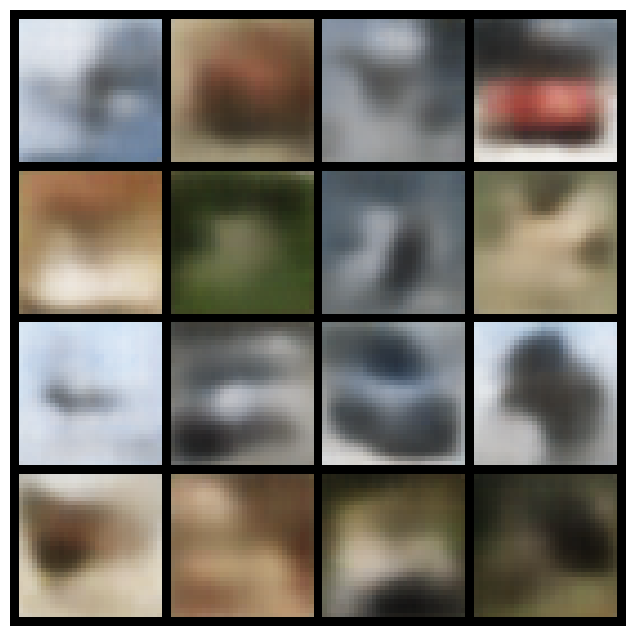

In [7]:
import matplotlib.pyplot as plt
import numpy as np

grid = vutils.make_grid(samples.cpu(), nrow=4) # Adjusted nrow to 4 for a 4x4 grid
plt.figure(figsize=(8,8)) # Adjusted figure size for better display of 4x4 grid
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.show()

#### Train and show images for Fully Connected VAE


Training VAE on CIFAR-10 dataset for 10 epochs...
Epoch 1, Avg Loss: 103.5399
Epoch 2, Avg Loss: 86.5548
Epoch 3, Avg Loss: 83.9208
Epoch 4, Avg Loss: 82.3262
Epoch 5, Avg Loss: 81.3789
Epoch 6, Avg Loss: 80.7103
Epoch 7, Avg Loss: 80.1074
Epoch 8, Avg Loss: 79.6370
Epoch 9, Avg Loss: 79.2307
Epoch 10, Avg Loss: 79.0150
Training complete.


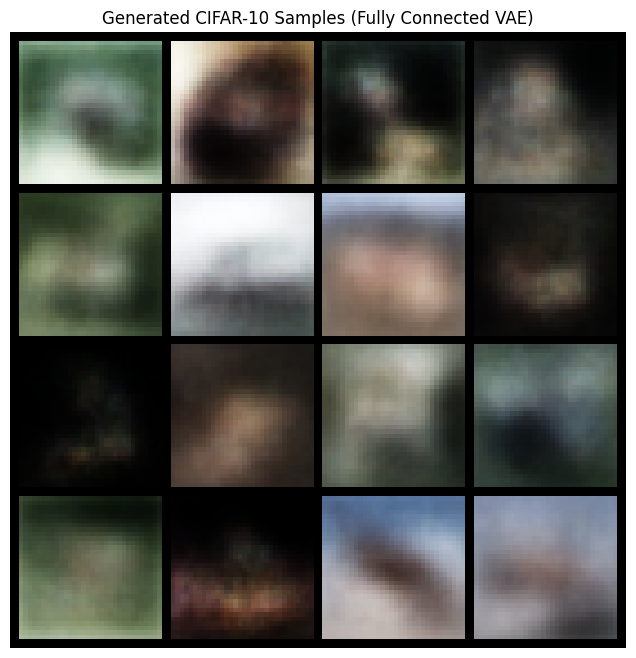

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VAE dimensions for CIFAR-10 (3x32x32 = 3072)
input_dim = 3072
hidden_dim = 400
latent_dim = 20

# Instantiate the VAE model
model_VAE = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Initialize the Adam optimizer
optimizer = optim.Adam(model_VAE.parameters(), lr=1e-3)

# Define the number of epochs for training
num_epochs = 10

# Redefine loss_function here to ensure it uses the correct dimensions
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

print(f"Training VAE on CIFAR-10 dataset for {num_epochs} epochs...")

# Training loop
for epoch in range(1, num_epochs + 1):
    model_VAE.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model_VAE(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch}, Avg Loss: {train_loss / len(train_loader.dataset):.4f}")

print("Training complete.")

#Generate and Display Samples

model_VAE.eval() # Set the model to evaluation mode

with torch.no_grad():
    # Generate random latent vectors
    z = torch.randn(16, latent_dim).to(device) # Generate 16 samples

    # Decode the latent vectors to generate images
    generated_images = model_VAE.decode(z).cpu()

    # Reshape the generated images back to 3D for CIFAR-10 (3 channels, 32x32)
    generated_images = generated_images.view(-1, 3, 32, 32)

    # Create a grid of images
    grid = vutils.make_grid(generated_images, nrow=4, padding=2, normalize=True)

    # Display the grid of images
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title("Generated CIFAR-10 Samples (Fully Connected VAE)")
    plt.axis('off')
    plt.show()

#### Comparison

Although both the fully connected VAE and the convolutional VAE produced somewhat blurry images, the outputs from the convolutional model were noticeably easier to interpret. In several instances, identifiable features could be seen within the images. For example, the legs of a horse were clearly visible. In contrast, the images generated by the fully connected VAE lacked any distinguishable characteristics, making it difficult to recognize the subjects at all.

### Task 2.2 Interpolate

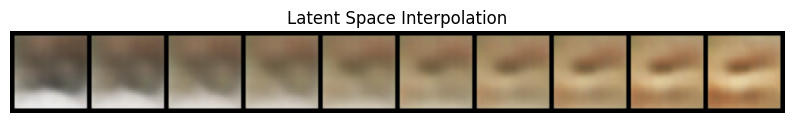

In [9]:
# Set the model into eval mode
model.eval()

data_iter = iter(train_loader)
images, _ = next(data_iter)
img1 = images[0].unsqueeze(0).to(device)
img2 = images[1].unsqueeze(0).to(device)

# Encode the images into latent space
with torch.no_grad():
    mu1, logvar1 = model.encode(img1)
    mu2, logvar2 = model.encode(img2)


    z1 = model.reparameterize(mu1, logvar1)
    z2 = model.reparameterize(mu2, logvar2)

# Interpolate between z1 and z2
steps = 10 # Reduced number of interpolation steps
z_list = []

for alpha in torch.linspace(0, 1, steps):
    z = z1 * (1 - alpha) + z2 * alpha
    z_list.append(z)

z_interp = torch.cat(z_list)

# Decode the interpolated points
with torch.no_grad():
    interp_images = model.decode(z_interp).cpu()

# Visualize Grid

grid = vutils.make_grid(interp_images, nrow=steps) # Adjusted nrow to match steps
plt.figure(figsize=(10,3)) # Adjusted figure size for fewer images
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off')
plt.title("Latent Space Interpolation")
plt.show()

### 2.3 SVHN dataset

In [10]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transformations for SVHN (32x32 already)
svhn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Instantiate the SVHN dataset
svhn_dataset = datasets.SVHN(
    root='./data',
    split='train',     \
    download=True,
    transform=svhn_transform
)

# Create a DataLoader
train_loader = DataLoader(
    svhn_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

print("SVHN dataset and DataLoader created successfully.")

100%|██████████| 182M/182M [00:02<00:00, 79.8MB/s]


SVHN dataset and DataLoader created successfully.


#### Re-Train model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinitialize the ConvVAE model
model_SVHN = ConvVAE(latent_dim=128).to(device)

# Reinitialize the Adam optimizer
optimizer = optim.Adam(model_SVHN.parameters(), lr=1e-3)

# Define the number of epochs for training
num_epochs = 25

print(f"Training ConvVAE on SVHN dataset for {num_epochs} epochs...")

# Loop through the specified number of epochs, calling the train function
for epoch in range(1, num_epochs + 1):
    model_SVHN.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model_SVHN(data)
        loss = loss_function_conv(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    print(f"Epoch {epoch}, Avg Loss: {total_loss / len(train_loader.dataset):.4f}")

print("Training complete.")

Training ConvVAE on SVHN dataset for 25 epochs...
Epoch 1, Avg Loss: 433.9772
Epoch 2, Avg Loss: 392.7536
Epoch 3, Avg Loss: 384.4824
Epoch 4, Avg Loss: 379.4921
Epoch 5, Avg Loss: 376.3381
Epoch 6, Avg Loss: 373.5811
Epoch 7, Avg Loss: 371.7935
Epoch 8, Avg Loss: 370.6370
Epoch 9, Avg Loss: 369.8581
Epoch 10, Avg Loss: 369.3894
Epoch 11, Avg Loss: 368.8673
Epoch 12, Avg Loss: 368.4268
Epoch 13, Avg Loss: 368.2229
Epoch 14, Avg Loss: 367.9777
Epoch 15, Avg Loss: 367.6414
Epoch 16, Avg Loss: 367.3922
Epoch 17, Avg Loss: 367.2417
Epoch 18, Avg Loss: 367.0960
Epoch 19, Avg Loss: 366.9284
Epoch 20, Avg Loss: 366.8575
Epoch 21, Avg Loss: 366.6413
Epoch 22, Avg Loss: 366.5603
Epoch 23, Avg Loss: 366.5099
Epoch 24, Avg Loss: 366.3559
Epoch 25, Avg Loss: 366.2406
Training complete.


#### Randomly sample from Latent Space


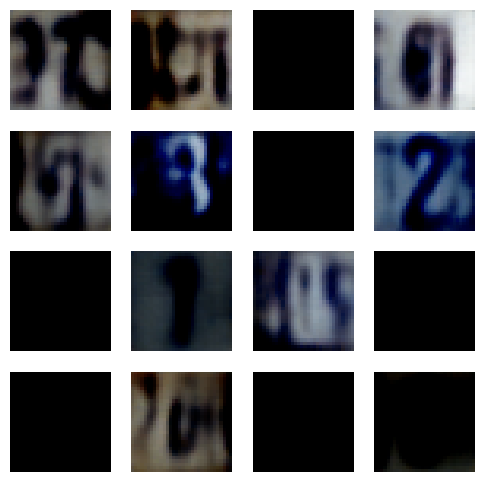

In [19]:
# Make sure model is in evaluation mode
model_SVHN.eval()

latent_dim = 128
num_samples = 16

# Random latent vectors
z = torch.randn(num_samples, latent_dim).to(device)

# Decode
with torch.no_grad():
    samples = model_SVHN.decode(z).cpu()

# Plot 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].permute(1,2,0))  # CxHxW -> HxWxC
    ax.axis('off')
plt.show()


# Interpolate bewteen two random vectors

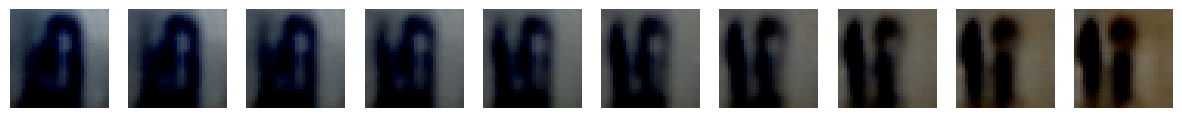

In [37]:
# Pick two random points
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)

num_interpolations = 10
interpolated_imgs = []

with torch.no_grad():
    for alpha in torch.linspace(0, 1, num_interpolations):
        z = (1 - alpha) * z1 + alpha * z2
        img = model_SVHN.decode(z)
        interpolated_imgs.append(img.cpu())

interpolated_imgs = torch.cat(interpolated_imgs, dim=0)

# Plot
fig, axes = plt.subplots(1, num_interpolations, figsize=(15,2))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_imgs[i].permute(1,2,0))
    ax.axis('off')
plt.show()


#### Varying latent dimensions

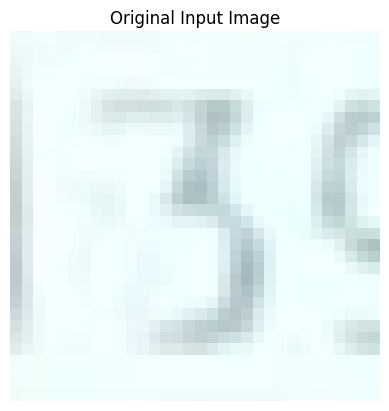

Traversing latent dimensions: [0, 14, 28, 42, 56, 70, 84, 98, 112, 127]


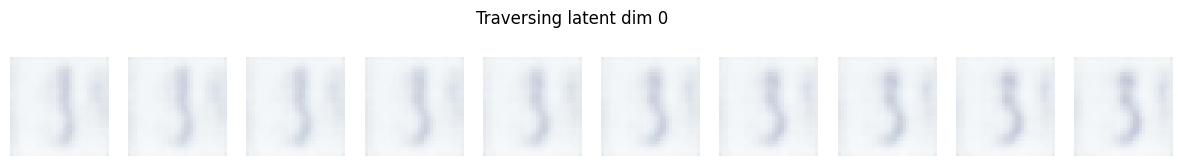

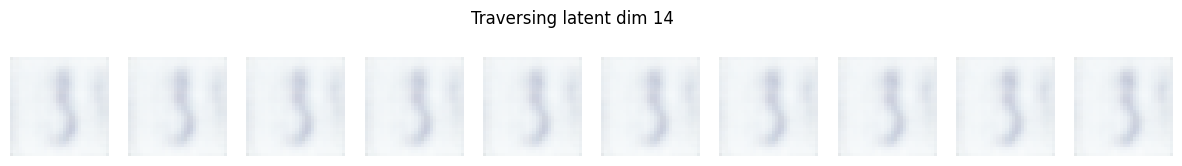

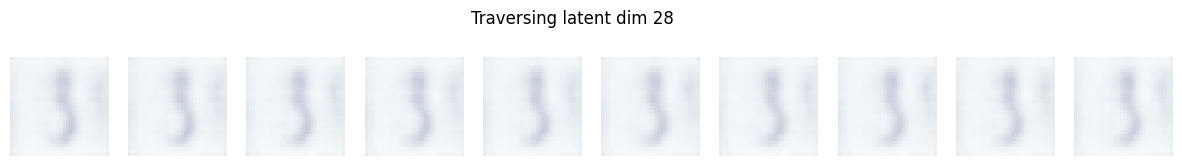

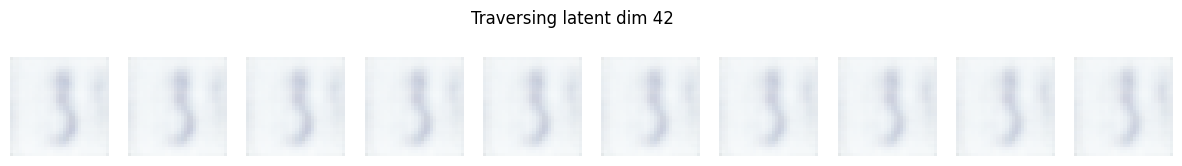

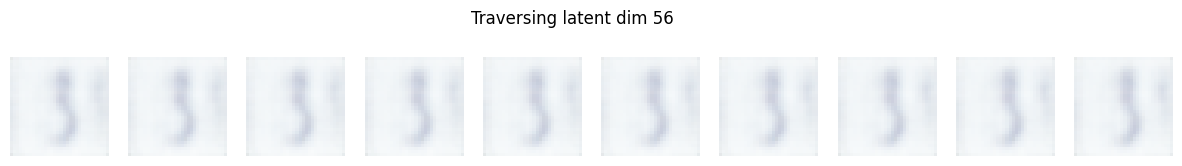

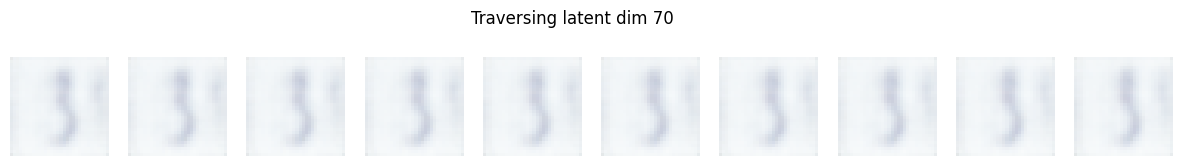

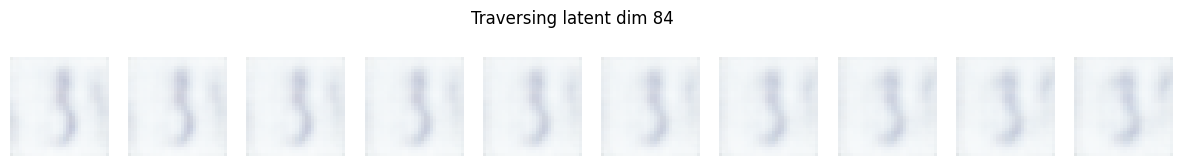

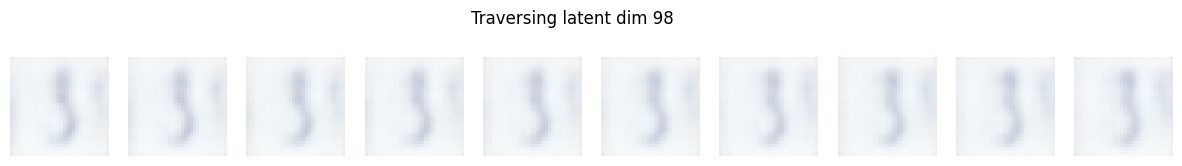

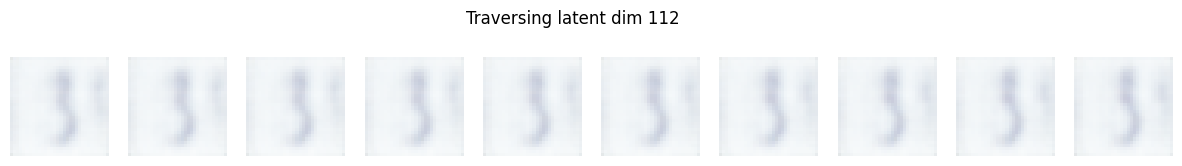

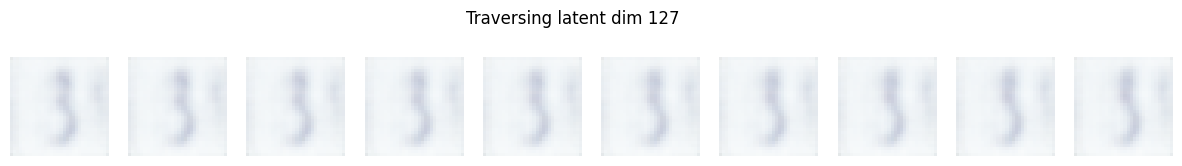

Decoder output range: 0.0 to 0.3364233672618866


In [53]:
import torch
import matplotlib.pyplot as plt

model_SVHN.eval()

svhn_test_dataset = datasets.SVHN(
    root='./data',
    split='test',
    download=True,
    transform=svhn_transform
)

test_loader = DataLoader(
    svhn_test_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


latent_dim = model_SVHN.fc_mu.out_features
num_steps = 10
values = torch.linspace(-3, 3, num_steps).to(device)  # smoother than -5→5

# Get one test image
data_iter = iter(test_loader)
img, _ = next(data_iter)
img = img[0:1].to(device)

# Show original image
plt.imshow(((img[0].cpu() + 1) / 2).permute(1,2,0))
plt.title("Original Input Image")
plt.axis('off')
plt.show()

# Encode to latent space
with torch.no_grad():
    base_mu, _ = model_SVHN.encode(img)

# Choose evenly spaced latent dimensions
max_dims_to_show = 10
num_dims = min(latent_dim, max_dims_to_show)

dims_to_traverse = torch.linspace(
    0, latent_dim - 1, steps=num_dims
).long()

print(f"Traversing latent dimensions: {dims_to_traverse.tolist()}")

# Traverse & Plot
for dim in dims_to_traverse:
    images = []

    with torch.no_grad():
        for val in values:
            z = base_mu.clone()
            z[0, dim] = val
            img_out = model_SVHN.decode(z)

            # unnormalize from [-1,1] → [0,1]
            img_out = (img_out + 1) / 2
            img_out = torch.clamp(img_out, 0, 1)

            images.append(img_out.cpu())

    images = torch.cat(images, dim=0)

    fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1,2,0))
        ax.axis('off')

    plt.suptitle(f"Traversing latent dim {dim.item()}")
    plt.show()


When traversing individual latent dimensions from a base latent vector, I observed that some dimensions had little to no effect on the reconstructed image, while others produced subtle changes in digit thickness, rotation, or color. Randomly sampling latent vectors from the prior produced plausible digit images, although some reconstructions were blurry or averaged, reflecting the smoothing effect of the VAE. Overall, the model's latent space captures continuous variations in digit appearance, but is not strong with respect to digit class.

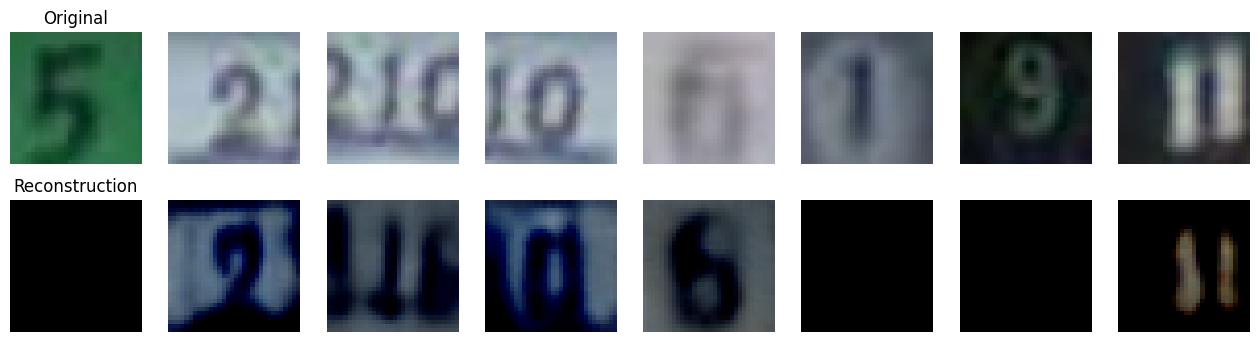

In [15]:
import matplotlib.pyplot as plt

# Define SVHN test dataset and loader
svhn_test_dataset = datasets.SVHN(
    root='./data',
    split='test',
    download=True,
    transform=svhn_transform # Use the same transform as train
)

test_loader = DataLoader(
    svhn_test_dataset,
    batch_size=128,
    shuffle=False, # No need to shuffle test data
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

model_SVHN.eval()
data_iter = iter(test_loader)
images, _ = next(data_iter)
images = images.to(device)

with torch.no_grad():
    recon, _, _ = model_SVHN(images)

# Show first 8 original and reconstructed images
n = 8
plt.figure(figsize=(16,4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i+1)
    orig = (images[i] + 1)/2  # rescale original [-1,1] -> [0,1]
    plt.imshow(orig.cpu().permute(1,2,0))
    ax.axis('off')
    if i == 0:
        ax.set_title("Original")

    # Reconstruction
    ax = plt.subplot(2, n, i+1+n)
    recon_img = torch.clamp(recon[i], 0, 1)  # clamp to [0,1]
    plt.imshow(recon_img.cpu().permute(1,2,0))
    ax.axis('off')
    if i == 0:
        ax.set_title("Reconstruction")

plt.show()



The reconstructed images generally capture the main shape and color of the original SVHN digits, but they often appear blurrier and less detailed. Fine features, such as sharp edges or exact background details, are smoothed out, and some reconstructions may appear as grey or black squares when the latent vector corresponds to a region the model has not learned well. This could potentially be fixed by extending the training over mroe epochs, but I did not expirement too much with this as the training time was taking quite awhile (I ran out of GPU usage with Colab) Overall, the reconstructions show that the ConvVAE captures the overall structure of the digits but loses some of the fine-grained detail present in the original images.

